# File for displaying calibrated spectograms

making use of the file ```zen.2459863.25263.sum.omni_vis.uvh5.tar.gz  ```

## PLotting an autocorrelation
using ```zen.2459863.25778.sum.autos.uvh5```


In [12]:
from matplotlib.pyplot import figure
from pyuvdata import UVData
import numpy as np

def listobs_uvh5(filename):
    """
    Print observation summary for a uvh5 file, similar to CASA's listobs.

    Parameters
    ----------
    filename : str
        Path to the .uvh5 file
    """
    # Read only metadata, not the actual data
    uv = UVData()
    uv.read(filename, read_data=False)

    print("=" * 80)
    print("OBSERVATION SUMMARY")
    print("=" * 80)
    print(f"\nFile: {filename}")

    # Telescope information
    if hasattr(uv, 'telescope') and uv.telescope is not None:
        if hasattr(uv.telescope, 'name') and uv.telescope.name is not None:
            print(f"Telescope: {uv.telescope.name}")
    elif hasattr(uv, 'telescope_name') and uv.telescope_name is not None:
        print(f"Telescope: {uv.telescope_name}")

    if hasattr(uv, 'instrument') and uv.instrument is not None:
        print(f"Instrument: {uv.instrument}")

    if hasattr(uv, 'object_name') and uv.object_name is not None:
        print(f"Object/Source: {uv.object_name}")

    # Telescope location
    print(f"\nTelescope Location:")
    try:
        if hasattr(uv, 'telescope') and uv.telescope is not None:
            lat, lon, alt = uv.telescope.location_lat_lon_alt_degrees
            print(f"  Latitude:  {lat:.6f} deg")
            print(f"  Longitude: {lon:.6f} deg")
            print(f"  Altitude:  {alt:.2f} m")
    except (AttributeError, TypeError):
        if hasattr(uv, 'telescope_location') and uv.telescope_location is not None:
            print(f"  XYZ coordinates: {uv.telescope_location}")

    # Time information
    print(f"\nTime Information:")
    is_lst_binned = False

    if hasattr(uv, 'time_array') and uv.time_array is not None and len(uv.time_array) > 0:
        unique_times = np.unique(uv.time_array)
        print(f"  Number of integrations: {len(unique_times)}")
        print(f"  Start time (JD): {unique_times[0]:.6f}")
        print(f"  End time (JD):   {unique_times[-1]:.6f}")

        if len(unique_times) > 1:
            time_diffs = np.diff(unique_times)
            if len(time_diffs) > 0:
                integration_time = np.median(time_diffs) * 24 * 3600  # in seconds
                print(f"  Integration time: {integration_time:.2f} seconds")

        if hasattr(uv, 'integration_time') and uv.integration_time is not None:
            if np.isscalar(uv.integration_time):
                print(f"  Integration time (from metadata): {uv.integration_time:.2f} seconds")
            else:
                print(f"  Integration time (from metadata): {np.median(uv.integration_time):.2f} seconds (median)")

    # Check for LST binning
    if hasattr(uv, 'lst_array') and uv.lst_array is not None and len(uv.lst_array) > 0:
        unique_lsts = np.unique(uv.lst_array)
        print(f"\nLST Information:")
        print(f"  Number of unique LSTs: {len(unique_lsts)}")
        print(f"  LST range: {unique_lsts[0]:.6f} - {unique_lsts[-1]:.6f} radians")
        print(f"  LST range: {np.degrees(unique_lsts[0]):.3f} - {np.degrees(unique_lsts[-1]):.3f} degrees")

        # Check if LST-binned: multiple integrations at same LST
        if hasattr(uv, 'Nbls') and uv.Nbls is not None:
            expected_nblts_per_time = uv.Nbls
            if hasattr(uv, 'Nblts') and uv.Nblts is not None:
                integrations_per_lst = uv.Nblts / len(unique_lsts)
                if integrations_per_lst > expected_nblts_per_time:
                    is_lst_binned = True
                    n_days_binned = int(round(integrations_per_lst / expected_nblts_per_time))
                    print(f"  ** LST-BINNED DATA DETECTED **")
                    print(f"  Estimated days binned: ~{n_days_binned}")

        # Alternative check: look at time vs LST relationship
        if len(unique_times) > 1 and len(unique_lsts) > 1:
            # In non-LST-binned data, each unique time should have a unique LST
            # In LST-binned data, different times can have the same LST
            if len(unique_times) > len(unique_lsts):
                is_lst_binned = True
                print(f"  ** LST-BINNED DATA DETECTED **")
                print(f"  ({len(unique_times)} time integrations → {len(unique_lsts)} LST bins)")

    # Frequency information
    print(f"\nSpectral Window Information:")
    if hasattr(uv, 'Nspws') and uv.Nspws is not None:
        print(f"  Number of spectral windows: {uv.Nspws}")

    if hasattr(uv, 'Nfreqs') and uv.Nfreqs is not None:
        print(f"  Number of channels: {uv.Nfreqs}")

    if hasattr(uv, 'freq_array') and uv.freq_array is not None and uv.freq_array.size > 0:
        freq_array = uv.freq_array[0] if uv.freq_array.ndim > 1 else uv.freq_array
        print(f"  Frequency range: {freq_array[0]/1e6:.6f} - {freq_array[-1]/1e6:.6f} MHz")

        if len(freq_array) > 1:
            chan_width = np.median(np.diff(freq_array)) / 1e3  # in kHz
            print(f"  Channel width: {chan_width:.3f} kHz")

    if hasattr(uv, 'channel_width') and uv.channel_width is not None:
        if np.isscalar(uv.channel_width):
            print(f"  Channel width (from metadata): {uv.channel_width/1e3:.3f} kHz")
        else:
            print(f"  Channel width (from metadata): {np.median(uv.channel_width)/1e3:.3f} kHz (median)")

    # Antenna information
    print(f"\nAntenna Information:")
    if hasattr(uv, 'telescope') and uv.telescope is not None:
        if hasattr(uv.telescope, 'Nants') and uv.telescope.Nants is not None:
            print(f"  Number of antennas: {uv.telescope.Nants}")

        if hasattr(uv.telescope, 'antenna_numbers') and uv.telescope.antenna_numbers is not None:
            ant_nums = uv.telescope.antenna_numbers.tolist()
            if len(ant_nums) <= 20:
                print(f"  Antenna numbers: {sorted(ant_nums)}")
            else:
                print(f"  Antenna numbers: {sorted(ant_nums)[:10]} ... {sorted(ant_nums)[-10:]}")
                print(f"    (showing first and last 10 of {len(ant_nums)} antennas)")

        if hasattr(uv.telescope, 'antenna_names') and uv.telescope.antenna_names is not None:
            ant_names = uv.telescope.antenna_names.tolist()
            if len(ant_names) <= 20:
                print(f"  Antenna names: {ant_names}")
            else:
                print(f"  Antenna names: {ant_names[:10]} ... {ant_names[-10:]}")
                print(f"    (showing first and last 10 of {len(ant_names)} antennas)")
    else:
        # Fallback for older pyuvdata versions
        if hasattr(uv, 'Nants_telescope') and uv.Nants_telescope is not None:
            print(f"  Number of antennas: {uv.Nants_telescope}")

        if hasattr(uv, 'antenna_numbers') and uv.antenna_numbers is not None:
            ant_nums = uv.antenna_numbers.tolist()
            if len(ant_nums) <= 20:
                print(f"  Antenna numbers: {sorted(ant_nums)}")
            else:
                print(f"  Antenna numbers: {sorted(ant_nums)[:10]} ... {sorted(ant_nums)[-10:]}")
                print(f"    (showing first and last 10 of {len(ant_nums)} antennas)")

        if hasattr(uv, 'antenna_names') and uv.antenna_names is not None:
            ant_names = uv.antenna_names.tolist()
            if len(ant_names) <= 20:
                print(f"  Antenna names: {ant_names}")
            else:
                print(f"  Antenna names: {ant_names[:10]} ... {ant_names[-10:]}")
                print(f"    (showing first and last 10 of {len(ant_names)} antennas)")

    # Baseline information
    print(f"\nBaseline Information:")
    if hasattr(uv, 'Nbls') and uv.Nbls is not None:
        print(f"  Number of baselines: {uv.Nbls}")

    if hasattr(uv, 'Nblts') and uv.Nblts is not None:
        print(f"  Number of baseline-times: {uv.Nblts}")

    if hasattr(uv, 'Nants_data') and uv.Nants_data is not None:
        print(f"  Number of antennas with data: {uv.Nants_data}")

    # Polarization information
    print(f"\nPolarization Information:")
    if hasattr(uv, 'Npols') and uv.Npols is not None:
        print(f"  Number of polarizations: {uv.Npols}")

    if hasattr(uv, 'polarization_array') and uv.polarization_array is not None:
        # Convert pol codes to strings
        pol_strings = []
        for pol in uv.polarization_array:
            pol_dict = {
                -5: 'XX', -6: 'YY', -7: 'XY', -8: 'YX',
                -1: 'RR', -2: 'LL', -3: 'RL', -4: 'LR',
                1: 'I', 2: 'Q', 3: 'U', 4: 'V'
            }
            pol_strings.append(pol_dict.get(pol, str(pol)))
        print(f"  Polarizations: {pol_strings}")

    # Phase information
    print(f"\nPhase Information:")
    if hasattr(uv, 'phase_type') and uv.phase_type is not None:
        print(f"  Phase type: {uv.phase_type}")

    if hasattr(uv, 'phase_center_catalog') and uv.phase_center_catalog is not None:
        print(f"  Number of phase centers: {len(uv.phase_center_catalog)}")

    # Data shape and units
    print(f"\nData Information:")
    shape_parts = []
    if hasattr(uv, 'Nblts') and uv.Nblts is not None:
        shape_parts.append(f"Nblts={uv.Nblts}")
    if hasattr(uv, 'Nspws') and uv.Nspws is not None:
        shape_parts.append(f"Nspws={uv.Nspws}")
    if hasattr(uv, 'Nfreqs') and uv.Nfreqs is not None:
        shape_parts.append(f"Nfreqs={uv.Nfreqs}")
    if hasattr(uv, 'Npols') and uv.Npols is not None:
        shape_parts.append(f"Npols={uv.Npols}")

    if shape_parts:
        print(f"  Data array shape: ({', '.join(shape_parts)})")

    if hasattr(uv, 'vis_units') and uv.vis_units is not None:
        print(f"  Visibility units: {uv.vis_units}")

    if is_lst_binned:
        print(f"\n  *** THIS IS LST-BINNED DATA ***")

    # Additional metadata
    if hasattr(uv, 'history') and uv.history is not None and uv.history.strip():
        print(f"\nHistory:")
        # Truncate history if it's too long
        history_lines = uv.history.split('\n')
        max_lines = 5
        if len(history_lines) <= max_lines:
            print(f"  {uv.history}")
        else:
            print(f"  {chr(10).join(history_lines[:max_lines])}")
            print(f"  ... ({len(history_lines) - max_lines} more lines)")

    print("\n" + "=" * 80)

    return is_lst_binned

# Example usage:
# is_binned = listobs_uvh5('your_file.uvh5')

In [14]:
from pyuvdata import UVData
import numpy as np
import matplotlib.pyplot as plt

uvd = UVData()
uvd.read_uvh5('/home/skib/Repos/RFI-Detection/src/zen.2459863.25778.sum.autos.uvh5')
#uvd.read('/home/skib/Repos/RFI-Detection/src/zen.2460797.50227.diff.autos.uvh5')
listobs_uvh5('/home/skib/Repos/RFI-Detection/src/zen.2459863.25778.sum.autos.uvh5')

OBSERVATION SUMMARY

File: /home/skib/Repos/RFI-Detection/src/zen.2460797.50227.diff.autos.uvh5
Telescope: HERA

Telescope Location:
  Latitude:  -30.721526 deg
  Longitude: 21.428304 deg
  Altitude:  1051.69 m

Time Information:
  Number of integrations: 2
  Start time (JD): 2460797.502212
  End time (JD):   2460797.502324
  Integration time: 9.66 seconds
  Integration time (from metadata): 9.66 seconds (median)

LST Information:
  Number of unique LSTs: 2
  LST range: 4.230503 - 4.231208 radians
  LST range: 242.390 - 242.430 degrees

Spectral Window Information:
  Number of spectral windows: 1
  Number of channels: 1536
  Frequency range: 46.920776 - 234.298706 MHz
  Channel width: 122.070 kHz
  Channel width (from metadata): 122.070 kHz (median)

Antenna Information:
  Number of antennas: 350
  Antenna numbers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] ... [340, 341, 342, 343, 344, 345, 346, 347, 348, 349]
    (showing first and last 10 of 350 antennas)
  Antenna names: ['HH0', 'HH1', 'HH2', 

False

(360, 1536, 2)
(1536,)
(1536,)


Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


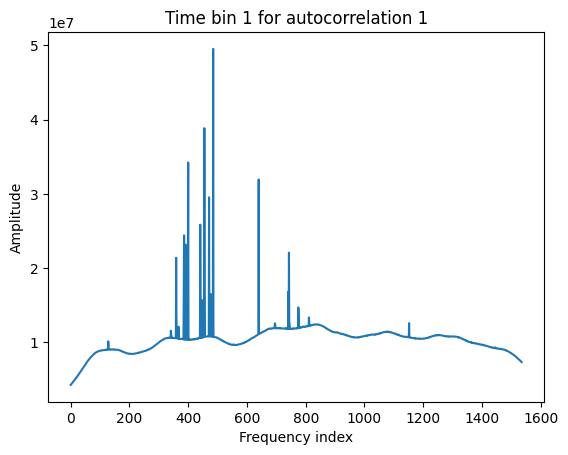

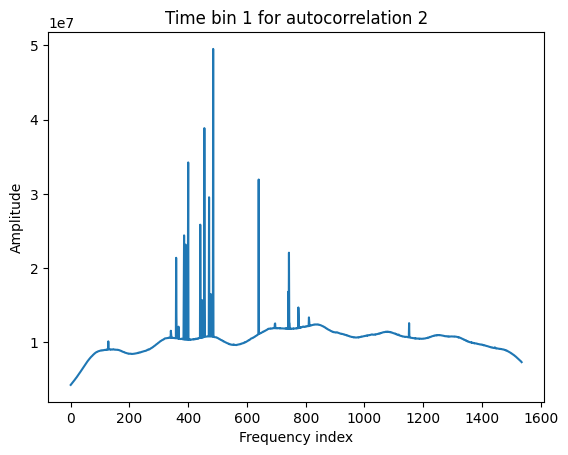

In [8]:
from pyuvdata import UVData
import numpy as np
import matplotlib.pyplot as plt

uvd = UVData()
uvd.read('/home/skib/Repos/RFI-Detection/src/zen.2459863.25778.sum.autos.uvh5')
#uvd.read('/home/skib/Repos/RFI-Detection/src/zen.2460797.50227.diff.autos.uvh5')
data = np.squeeze(uvd.data_array)
print(data.shape)

time_one = data[0,:,0]
time_two = data[0,:,1]
print (time_one.shape)
print(time_two.shape)
plt.plot(range(len(time_one)), time_one)
plt.xlabel("Frequency index")
plt.ylabel("Amplitude")
plt.title("Time bin 1 for autocorrelation 1")
plt.show()

plt.plot(range(len(time_two)), time_one)
plt.xlabel("Frequency index")
plt.ylabel("Amplitude")
plt.title("Time bin 1 for autocorrelation 2")
plt.show()